# Foundations of deep learning - HW1
Omer Koren & Edan Zwick

In [1]:
import part1
import part2
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from numpy.random import default_rng
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## ***Part 1 - Setup and baseline***

We will begin with downloading the datasets, and getting baseline results using SVM classification.First step is downloading the CIFAR dataset. We will only use a subsample, but we will download the whole set and later define the subsets used for the NNs. We will however define a transformation that will be used in part 2 (get items as flattened tensors).

In [2]:
t = part2.get_transformation() # ToTensor, flatten.
fullTrain = torchvision.datasets.CIFAR10('datasets/CIFAR', train=True, transform=t, target_transform=part2.OneHot(), download=True)
fullTest  = torchvision.datasets.CIFAR10('datasets/CIFAR', train=False, transform=t, target_transform=part2.OneHot(), download=True)

Files already downloaded and verified
Files already downloaded and verified


We will now create random masks to represent the chosen subset we will use:

In [3]:
rng = default_rng(42) # keeping dataset consistent
trainMask = rng.choice(len(fullTrain), len(fullTrain)//10, replace=False)
testMask =  rng.choice(len(fullTest), len(fullTest)//10, replace=False)

Narrowing the datasets that we will use:

In [4]:
trainData   = fullTrain.data[trainMask]
trainLabels = np.array(fullTrain.targets)[trainMask]
testData    = fullTest.data[testMask]
testLabels  = np.array(fullTest.targets)[testMask]
print('Dataset shapes: Train - {}, Test - {}'.format(trainData.shape,testData.shape))

Dataset shapes: Train - (5000, 32, 32, 3), Test - (1000, 32, 32, 3)


Flattening out the arrays:

In [5]:
trainData = trainData.reshape(trainData.shape[0],-1)
testData  = testData.reshape(testData.shape[0],-1)
print('Dataset shapes: Train - {}, Test - {}'.format(trainData.shape,testData.shape))

Dataset shapes: Train - (5000, 3072), Test - (1000, 3072)


Now lets get down to buisness, train and evaluate the SVM baseline model.
To get a reasonable result we will use a grid search to find the best parameters for the regularization constant and the Gamma paramater for the RBF kernel. As this is a lengthy process, the defult option in this notebook is to run with the optimal values we already found.

In [6]:
crossValidate = False

starting with the vanila linear SVM:

In [7]:
if crossValidate:
    params = part1.cross_validate(trainData, trainLabels, 'linear')
    C = params['C']
    print('paramaters chosen for the svm model: {}'.format(params))
else:
    C = 1e-07
linearModel = svm.SVC(C,'linear')
linearModel.fit(trainData, trainLabels)
print('done')

done


Linear svm accuracy on test set:0.398
confusion matrix:


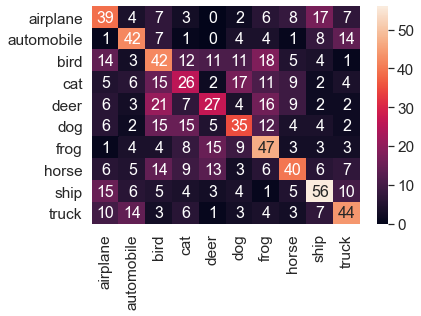

In [85]:
prediction = linearModel.predict(testData)
score = accuracy_score(testLabels, prediction)
print('Linear svm accuracy on test set:{}'.format(score))
print('confusion matrix:')
part1.confusion(testLabels, prediction, fullTrain.classes)

RBF kernel:

In [86]:
if crossValidate:
    params = part1.cross_validate(trainData, trainLabels, 'rbf')
    C = params['C']
    gamma = params['gamma']
    print('paramaters chosen for the svm model: {}'.format(params))
else:
    C = 100
    gamma = 8.32e-08
rbfModel = svm.SVC(C, kernel='rbf', gamma=gamma)
rbfModel.fit(trainData, trainLabels)
print('done')

done


Linear svm accuracy on test set:0.435
confusion matrix:


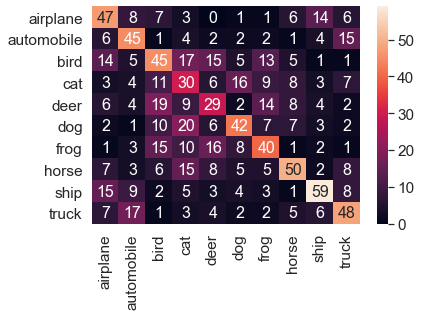

In [87]:
prediction = rbfModel.predict(testData)
score = accuracy_score(testLabels, prediction)
print('RBF svm accuracy on test set:{}'.format(score))
print('confusion matrix:')
part1.confusion(testLabels, prediction, fullTrain.classes)

## ***Part 2 - Feed Forward Neural Network***


In this section we need to implement using low-level API's, a feed forward fully connected NN.
We chose to use pyTorch as our framework.
First thing we need to do is to define the subset of the data set which we will be working with. Note that we already defined a transformation on the data such that it will be easy to manipulate. This includes:
- Transforming Images to tensors.
- Flattening the tensors.
- Adding constant 1 dimention to replace bias in FC layers.

The data set is already normalized to [0,1]

As we were instructed not to use the torch NN module which includes loss classes, (but were insructed that NN.functional is OK) we needed to use the torch.nn.functional.binary_cross_entropy which takes a one hot encoded vector as the target (instead of class). So we deployed a transformation on targets to one hot vectors.

In [6]:
trainData = torch.utils.data.Subset(fullTrain, trainMask)
testData  = torch.utils.data.Subset(fullTest, testMask)

#### Q1 - SGD
Next up, we'll choose paramaters our FC feed forward network.
All the components were implemented in part2.py using low level API's. The only true constants now are the network's dimentions:

In [7]:
in_dim = np.prod(fullTrain.data[0].shape)
hidden_dim = [256]
out_dim = 10

As we will be will be cross validating, we need to set aside a validation set from the train data. We'll reserve 20% (1,000) as validation and create loaders per each.

In [8]:
train, validation = torch.utils.data.random_split(trainData, [(4 * len(trainData)) // 5, len(trainData) // 5])
train_loader = torch.utils.data.DataLoader(train, batch_size=256 , shuffle=True, num_workers=4)
validation_loader  = torch.utils.data.DataLoader(validation, batch_size=256 , shuffle=False, num_workers=4)

Next, we'll preform a grid search on the network's hyperparamaters. We'll start with the learning rate and momentum. In this step we'll initialize weights std to 0.2. We'll later cross validate this hyper-paramater as well. Each training trial will be done for 75 epochs.

To save time on non GPU machines, the defult execution is to use pre-pickled results: 

In [9]:
learning_rates = np.linspace(1e-2,1,12)
momentum = np.linspace(0.6,0.99,12)
do_grid_search = False

In [10]:
if do_grid_search:
    best_params, best_loss, loss_heat_map, acc_heat_map = part2.optimizer_grid_search(train_loader, validation_loader, learning_rates, momentum, in_dim, out_dim, hidden_dim, std=0.2, verbose=True)
else:
    with open('resources/loss_heat_map.pkl', 'rb') as f:
        loss_heat_map = pickle.load(f)
    with open('resources/acc_heat_map.pkl', 'rb') as f:
        acc_heat_map = pickle.load(f)

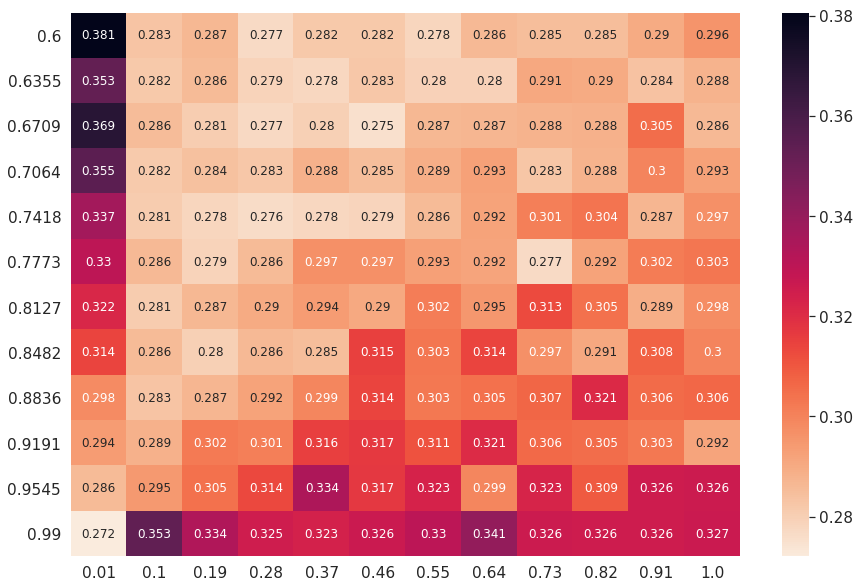

In [11]:
part2.show_heat_map(loss_heat_map, learning_rates, momentum, xlabel='Learning rates', ylabel='Momentum', invert=True)

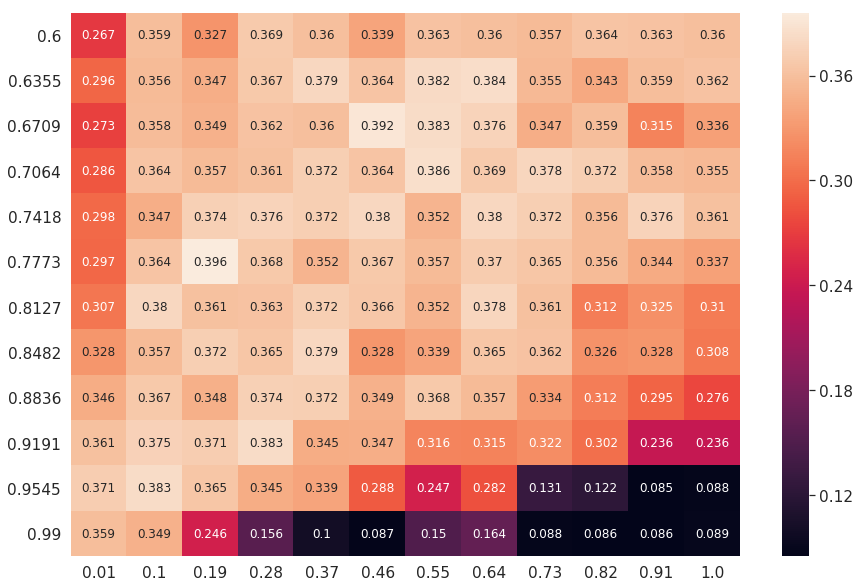

In [12]:
part2.show_heat_map(acc_heat_map, learning_rates, momentum, xlabel='Learning rates', ylabel='Momentum')

Lookig at the losses and the accuracy heat maps: the best results of the grid search were yielded by setting the learning rate to 0.2 and momentum to 0.77. Let's move forward to finding the optimal weights standard deviation.

In [13]:
stds = np.linspace(0.01,0.3,30)

In [14]:
if do_grid_search:
    best_params, best_loss, heat_map = part2.weights_grid_search(train_loader, validation_loader, stds, in_dim, out_dim, hidden_dim, lr=0.2, m=0.77, verbose=False)
    print('best loss is yielded by: {}'.format(best_params))
else:
    with open('resources/weight_heat_map.pkl', 'rb') as f:
        heat_map = pickle.load(f)

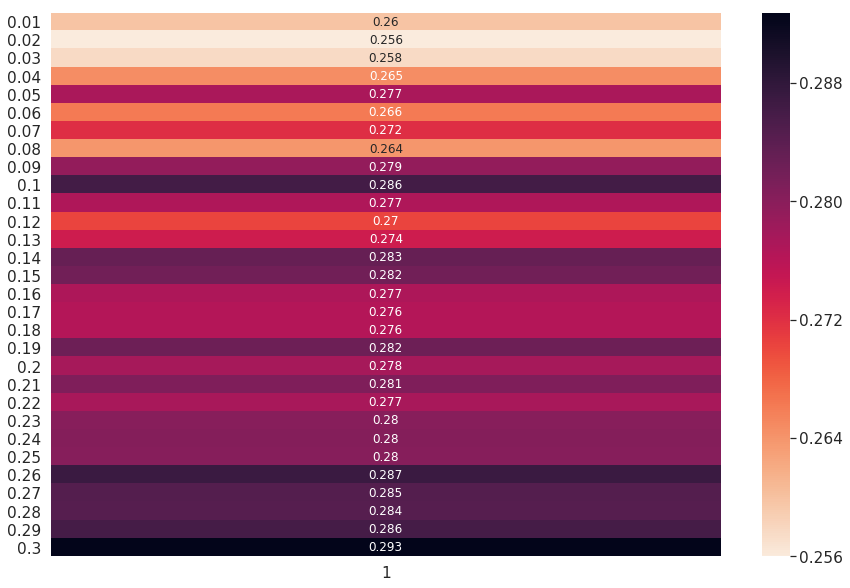

In [15]:
part2.show_heat_map(heat_map, [1], stds, xlabel='Learning rates', ylabel='Momentum', invert=True)

As can be seen in the above heat map, the best loss is yielded by setting std=0.02.
Now we can try and run the net, plotting loss and accuracy per epoch, and per train / test sets.
As we are done with the cross validation, we will now train on the entire train set (unify the train set back in).

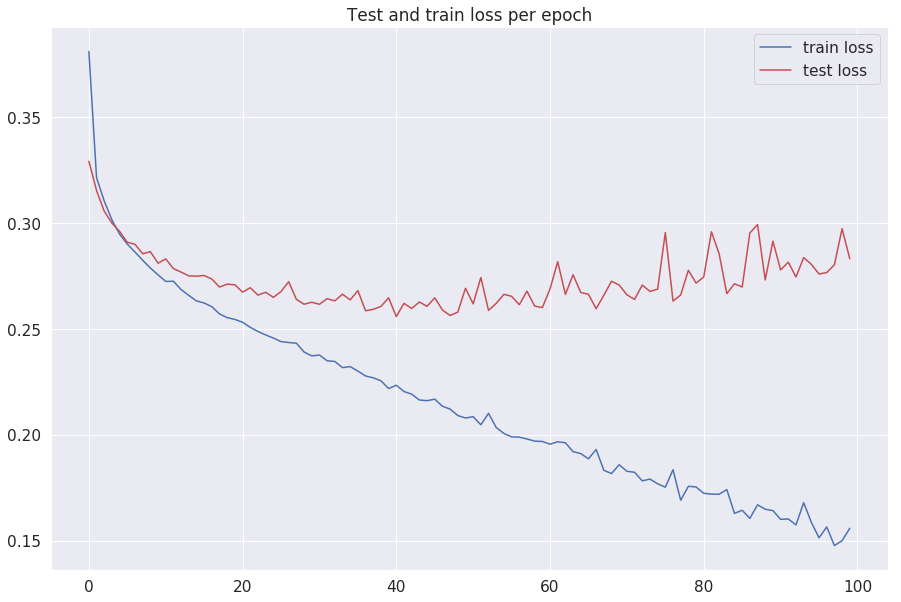

Final test loss: 0.2831902022361755


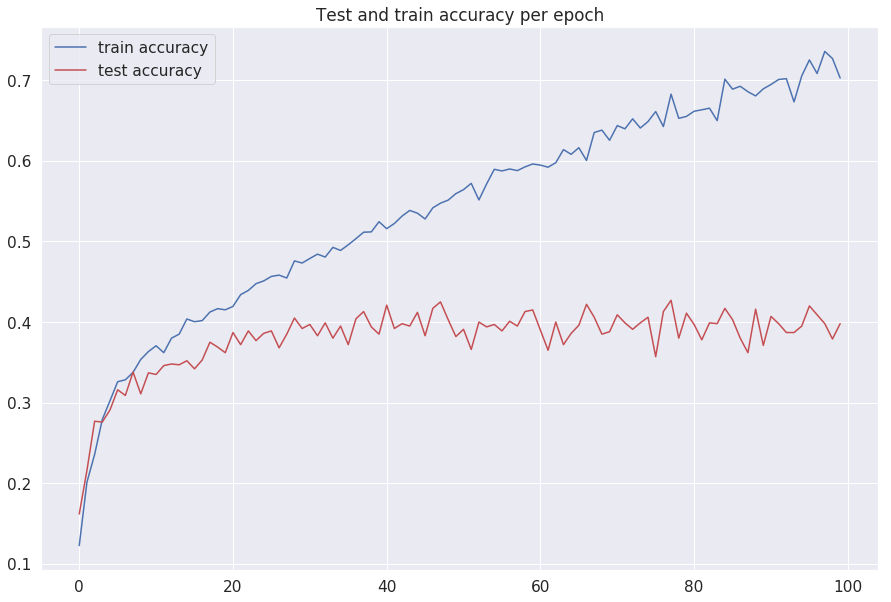

Final test accuracy: 0.398


In [51]:
# restore full datasets
train_loader = torch.utils.data.DataLoader(trainData, batch_size=256 , shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(testData, batch_size=256 , shuffle=False, num_workers=4)

# initialize net
net = part2.Net(in_dim, out_dim, hidden_dim, std=0.02)
optimizer = torch.optim.SGD(net.params(), lr=0.2, momentum=0.77)
epochs = 100

# Train and plot results.
sgd_train_losses, sgd_train_accs, sgd_test_losses, sgd_test_accs = part2.train(net, train_loader, optimizer, test_set=test_loader, verbose=False, num_epochs=epochs)
part2.plot_train_test(sgd_train_losses, sgd_test_losses, epochs, label_name='loss')
print('Final test loss: {}'.format(sgd_test_losses[-1]))
part2.plot_train_test(sgd_train_accs, sgd_test_accs, epochs, label_name='accuracy')
print('Final test accuracy: {}'.format(sgd_test_accs[-1]))
print('Best test accuracy: {}'.format(max(sgd_test_accs)))

#### Q2 - Adam
Now we will see if the Adam optimizer gets us any better. We shall preform grid search on the best paramaters. As before, unless stated o.w. we will load these params from memory.

In [ ]:
train, validation = torch.utils.data.random_split(trainData, [(4 * len(trainData)) // 5, len(trainData) // 5])
train_loader = torch.utils.data.DataLoader(train, batch_size=256 , shuffle=True, num_workers=4)
validation_loader  = torch.utils.data.DataLoader(validation, batch_size=256 , shuffle=False, num_workers=4)

learning_rates = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2]
betas = [(0.99,0.9999)] + [(0.9/10**i, 0.999/10**i) for i in range(8)]
do_grid_search = False

In [ ]:
if do_grid_search:
    best_params, best_loss, adam_loss_heat_map, adam_acc_heat_map = part2.adam_grid_search(train_loader, validation_loader, learning_rates, betas, in_dim, out_dim, hidden_dim, std=0.02, verbose=False)
    with open('resources/adam_loss_heat_map.pkl', 'wb') as f:
        pickle.dump(adam_loss_heat_map, f)
    with open('resources/adam_acc_heat_map.pkl', 'wb') as f:
        pickle.dump(adam_acc_heat_map, f)
else:
    with open('resources/adam_loss_heat_map.pkl', 'rb') as f:
        adam_loss_heat_map = pickle.load(f)
    with open('resources/adam_acc_heat_map.pkl', 'rb') as f:
        adam_acc_heat_map = pickle.load(f)

In [ ]:
part2.show_heat_map(adam_loss_heat_map, learning_rates, betas, xlabel='Learning rates', ylabel='Momentum', invert=True)

In [ ]:
part2.show_heat_map(adam_acc_heat_map, learning_rates, betas, xlabel='Learning rates', ylabel='Momentum')

A reasonable choice would be to take: lr=0.0005 and betas=(0.9,0.999).
No we can again, watch how our network trains:

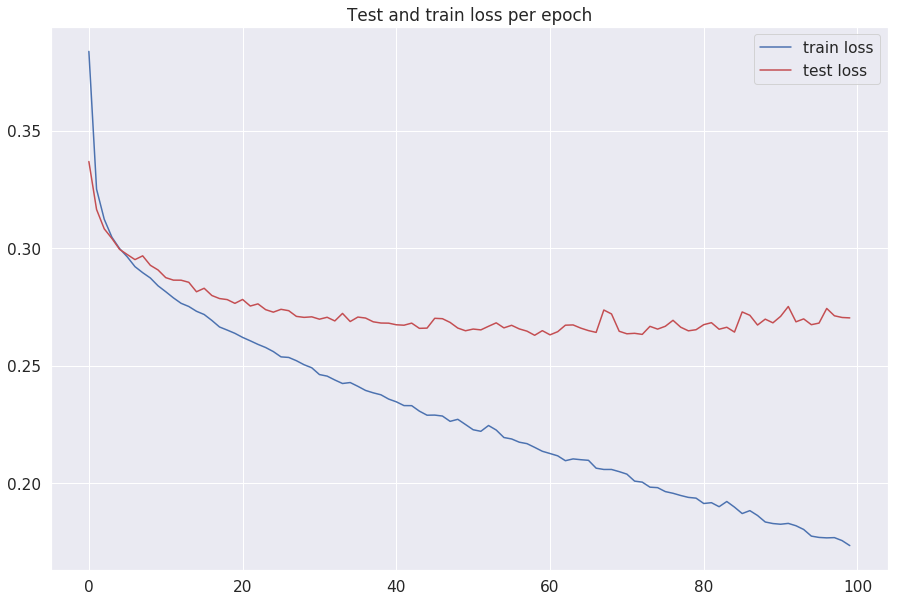

Final test loss: 0.2703779473304749


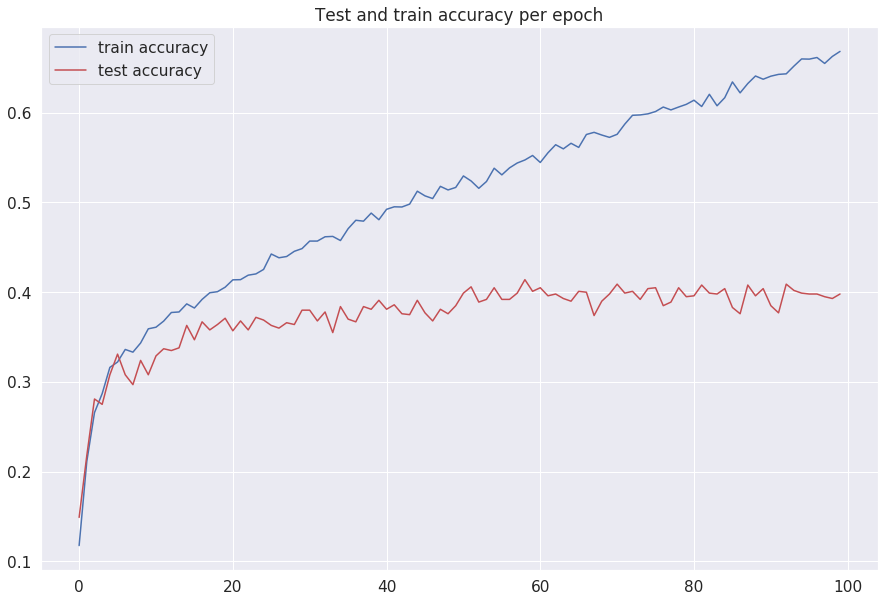

Final test accuracy: 0.398
Best test accuracy: 0.414


In [52]:
# restore full datasets
train_loader = torch.utils.data.DataLoader(trainData, batch_size=256 , shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(testData, batch_size=256 , shuffle=False, num_workers=4)

# initialize net
net = part2.Net(in_dim, out_dim, hidden_dim, std=0.02)
optimizer = torch.optim.Adam(net.params(), lr=0.0005, betas=(0.9,0.999))
epochs = 100

# run and plot results
adam_train_losses, adam_train_accs, adam_test_losses, adam_test_accs = part2.train(net, train_loader, optimizer, test_set=test_loader, verbose=False, num_epochs=epochs)
part2.plot_train_test(adam_train_losses, adam_test_losses, epochs, label_name='loss')
print('Final test loss: {}'.format(adam_test_losses[-1]))
part2.plot_train_test(adam_train_accs, adam_test_accs, epochs, label_name='accuracy')
print('Final test accuracy: {}'.format(adam_test_accs[-1]))

print('Best test accuracy: {}'.format(max(adam_test_accs)))

We can see that using the adam optimizer in fact converged a bit slower, but was more stable when approaching the optimum. Comparing the two optimizors: 

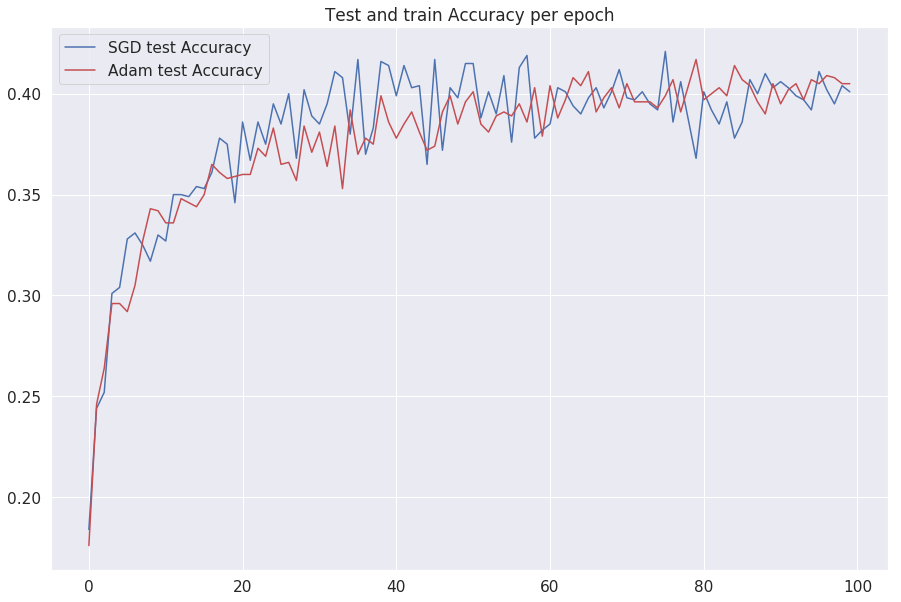

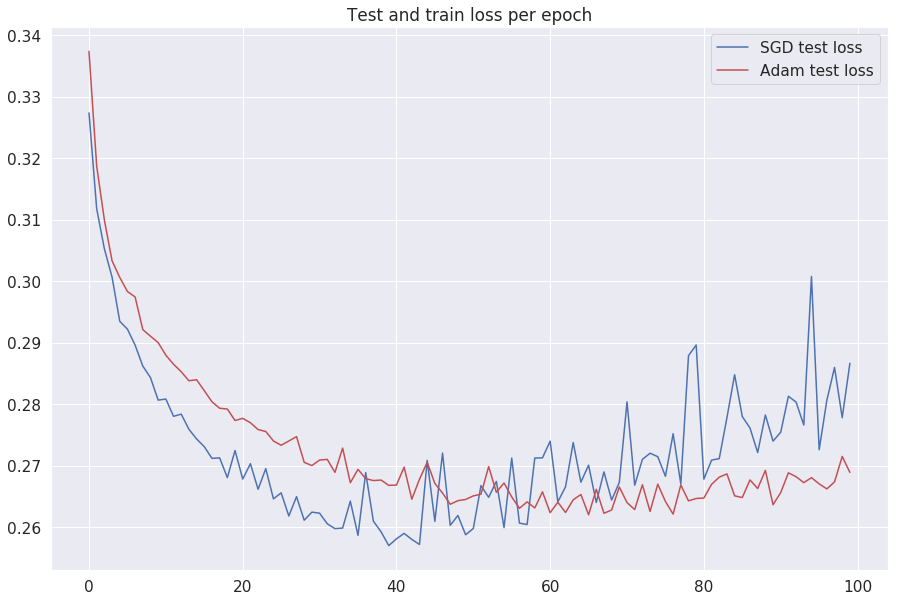

In [215]:
part2.plot_train_test(sgd_test_losses, adam_test_losses, epochs, label_name='loss', cat1 = 'SGD test ', cat2 = 'Adam test ')
part2.plot_train_test(sgd_test_accs, adam_test_accs, epochs, label_name='Accuracy', cat1 = 'SGD test ', cat2 = 'Adam test ')

#### Q3 - Initialization
Now lets test how our network behaves when we utilize Xavier initialization.

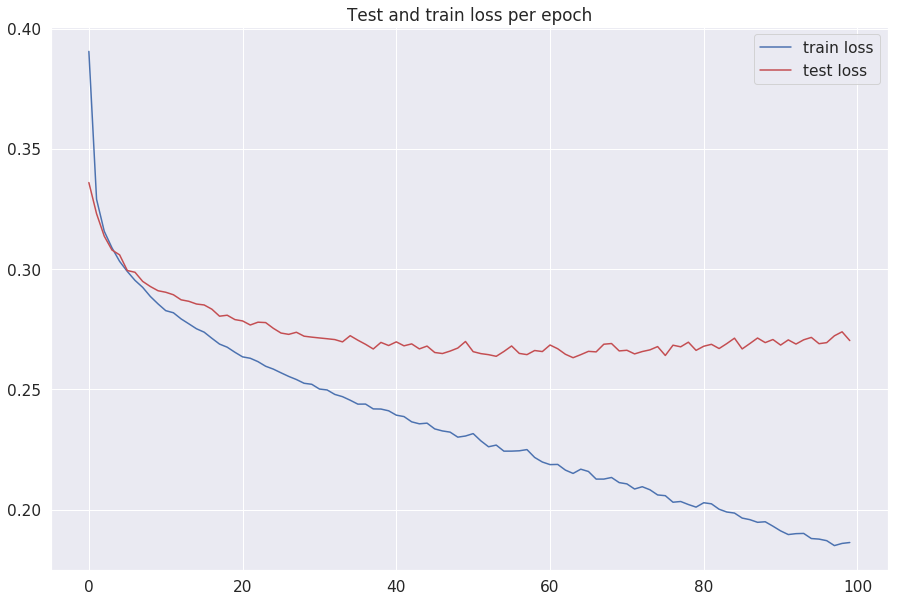

Final test loss: 0.18635204434394836


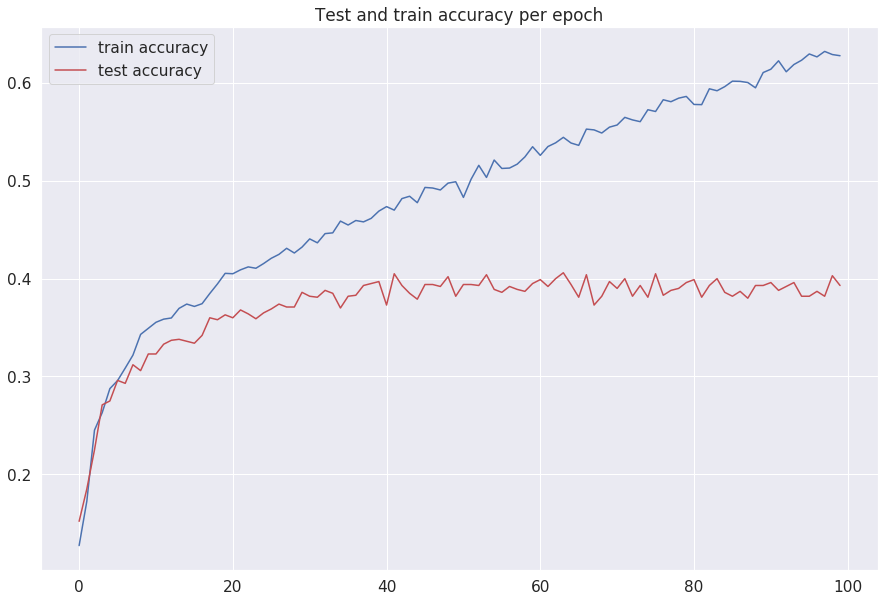

Final test accuracy: 0.393
Best test accuracy: 0.406


In [60]:
# restore full datasets
train_loader = torch.utils.data.DataLoader(trainData, batch_size=256 , shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(testData, batch_size=256 , shuffle=False, num_workers=4)

# initialize net
net = part2.Net(in_dim, out_dim, hidden_dim, dropout_p = p, xavier = True)
optimizer = torch.optim.Adam(net.params(), lr=0.0005, betas=(0.9,0.999))
epochs = 100

# run and plot results
xavier_train_losses, xavier_train_accs, xavier_test_losses, xavier_test_accs = part2.train(net, train_loader, optimizer, test_set=test_loader, verbose=False, num_epochs=epochs)
part2.plot_train_test(xavier_train_losses, xavier_test_losses, epochs, label_name='loss')
print('Final test loss: {}'.format(xavier_train_losses[-1]))
part2.plot_train_test(xavier_train_accs, xavier_test_accs, epochs, label_name='accuracy')
print('Final test accuracy: {}'.format(xavier_test_accs[-1]))

print('Best test accuracy: {}'.format(max(xavier_test_accs)))

#### Q4 - Regularization
We will now try to experiment with weight decay and dropout.
We'll begin by preforming a 1-d search on the best results we can yield using weight decay, as we are cross validating we will again seperate a random validation set.

In [19]:
train, validation = torch.utils.data.random_split(trainData, [(4 * len(trainData)) // 5, len(trainData) // 5])
train_loader = torch.utils.data.DataLoader(train, batch_size=256 , shuffle=True, num_workers=4)
validation_loader  = torch.utils.data.DataLoader(validation, batch_size=256 , shuffle=False, num_workers=4)

weight_decays = np.linspace(0.1e-3,0.3,30)
do_grid_search = False

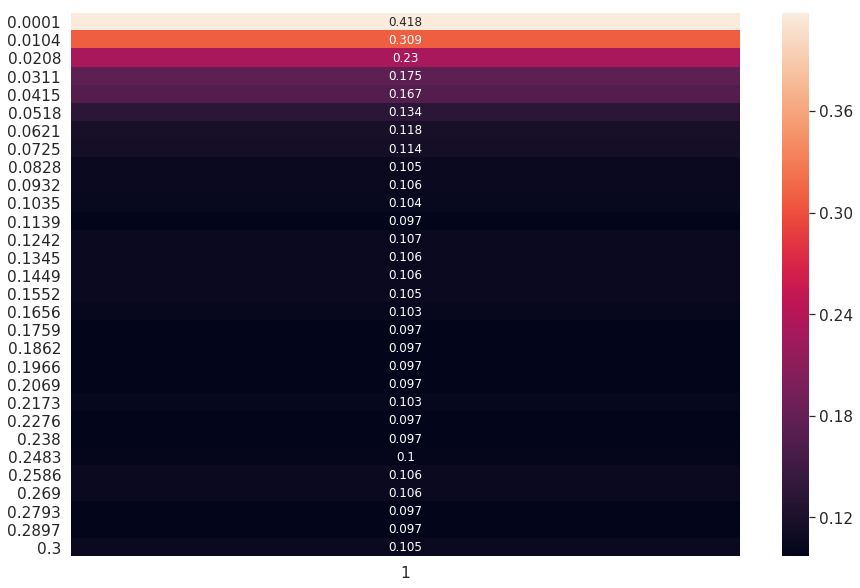

In [20]:
if do_grid_search:
    best_params, best_loss, decay_acc_heat_map = part2.adam_decay_search(train_loader, validation_loader, weight_decays, in_dim, out_dim, hidden_dim, lr=0.0005, betas=(0.9,0.999) ,std=0.02, verbose=False)
    with open('resources/decay_acc_heat_map.pkl', 'wb') as f:
        pickle.dump(decay_acc_heat_map, f)
else:
    with open('resources/decay_acc_heat_map.pkl', 'rb') as f:
        decay_acc_heat_map = pickle.load(f)
part2.show_heat_map(decay_acc_heat_map, [1], weight_decays, invert=False)

It seems as though L2 regularization does not help improve the preformance of our network.

Next up we experiment with dropout, we will check how our Adam optimized network preforms with this regularization method. Note that we will use inverted dropout: all weights are scaled during train time by (1/p) so their expectancy at train and test time will remain the same.

In [36]:
train, validation = torch.utils.data.random_split(trainData, [(4 * len(trainData)) // 5, len(trainData) // 5])
train_loader = torch.utils.data.DataLoader(train, batch_size=256 , shuffle=True, num_workers=4)
validation_loader  = torch.utils.data.DataLoader(validation, batch_size=256 , shuffle=False, num_workers=4)

dropout_pobs = np.linspace(0.01,0.5,15)
#print(dropout_pobs)
do_grid_search = True

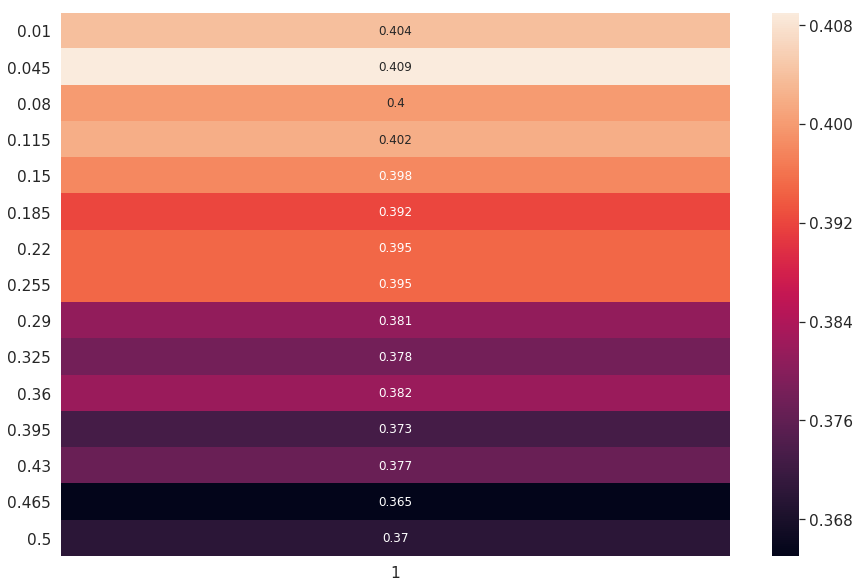

In [37]:
if do_grid_search:
    best_params, best_loss, dropout_acc_heat_map = part2.adam_dropout_search(train_loader, validation_loader, dropout_pobs, in_dim, out_dim, hidden_dim, lr=0.0005, betas=(0.9,0.999) ,std=0.02, verbose=False)
    with open('resources/dropout_acc_heat_map.pkl', 'wb') as f:
        pickle.dump(dropout_acc_heat_map, f)
else:
    with open('resources/dropout_acc_heat_map.pkl', 'rb') as f:
        dropout_acc_heat_map = pickle.load(f)
part2.show_heat_map(dropout_acc_heat_map, [1], dropout_pobs, invert=False)

It seems as though some improvment is gained by using drop out with probability of: 0.05 yields the best results.

Now, lets use these paramaters to train the model again.

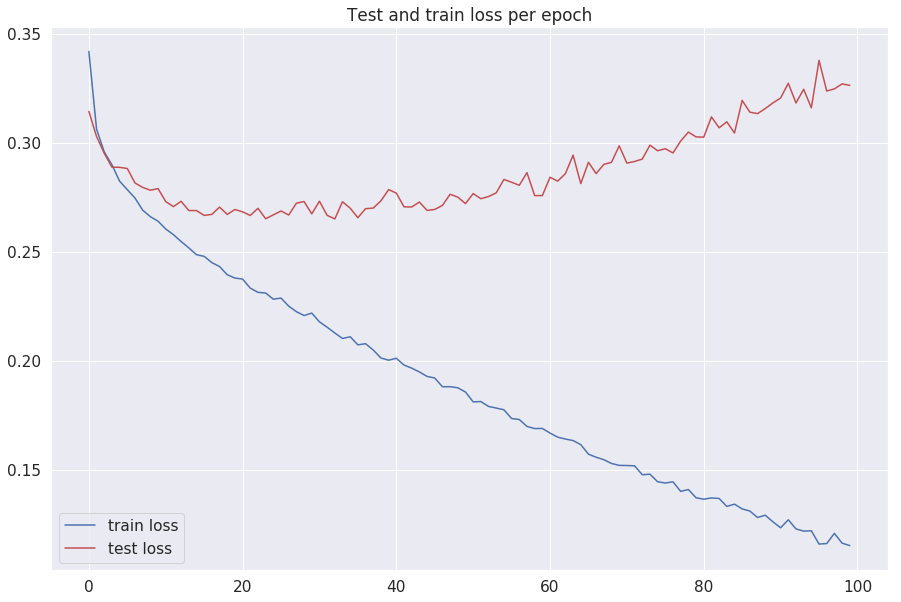

Final test loss: 0.11523191630840302


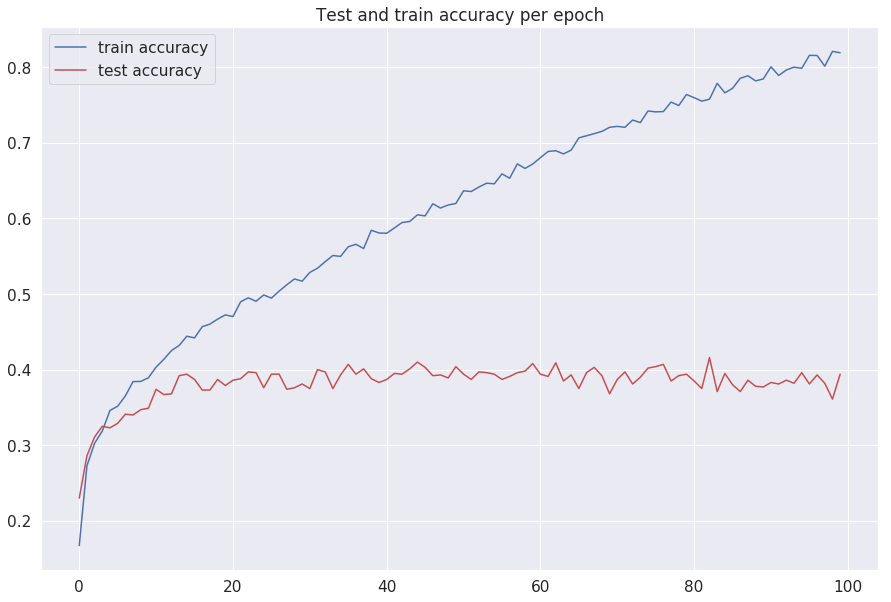

Final test accuracy: 0.394


In [46]:
p = 0.05

# restore full datasets
train_loader = torch.utils.data.DataLoader(trainData, batch_size=256 , shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(testData, batch_size=256 , shuffle=False, num_workers=4)

# initialize net
net = part2.Net(in_dim, out_dim, hidden_dim, xavier = True, dropout_p = p)
optimizer = torch.optim.Adam(net.params(), lr=0.0005, betas=(0.9,0.999))
epochs = 100

# run and plot results
dropout_train_losses, dropout_train_accs, dropout_test_losses, dropout_test_accs = part2.train(net, train_loader, optimizer, test_set=test_loader, verbose=False, num_epochs=epochs)
part2.plot_train_test(dropout_train_losses, dropout_test_losses, epochs, label_name='loss')
print('Final test loss: {}'.format(dropout_train_losses[-1]))
part2.plot_train_test(dropout_train_accs, dropout_test_accs, epochs, label_name='accuracy')
print('Final test accuracy: {}'.format(dropout_test_accs[-1]))
print('Best test accuracy: {}'.format(max(dropout_test_accs)))